In [1]:
!pip install -r requirements.txt;
!pip install matplotlib;

In [2]:
Bukidnon_Data = '1z35Kyga40hhoGBEQIY9jReY6z1wmnsnlUVw-pFEaBhg'

In [3]:
# import input dataset
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# quantities of food items
q = read_sheets(Bukidnon_Data,sheet='Quantities')
q.replace(0, np.nan, inplace=True)
q.set_index(['i', 't', 'm'], inplace=True)

# food expenditure
x = read_sheets(Bukidnon_Data,sheet='Expenditures')
x.columns.name = 'j'
# household characteristics
d = read_sheets(Bukidnon_Data,sheet="HH Characteristics")

# keep a copy
d_copy = d

# x may have duplicate columns
x = x.groupby('j',axis=1).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x.set_index(['i','t','m']))

# fct
#fct = read_sheets(Bukidnon_Data,sheet="FCT")
#fct = fct.set_index('j')
#fct.columns.name = 'n'

#fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))


# rdi
rdi = pd.read_csv("rdi.csv")

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


In [4]:
# read in additional data from the Bukidnon survey

# major crop production
import pandas as pd
crops = pd.read_stata('b3m.dta')

crops = crops[crops.m4a != 'Crop to be harvested']
crops = crops[crops.m4a != 'Sold as a standing crop']
crops = crops[crops.m4a != 'Dont Know']

crops = crops[crops['m4b'].str.contains("Ton|Kilo")==True]

# construct variables: production of sugar, rice, yellow corn, white corn, rubber, and coconut, in kilograms
variables = ['Sugar', 'Rice', 'Yellow Corn', 'White Corn', 'Rubber', 'Coconut']

# construct hh characteristic tables, each for one additional variable
tables = []

for v in variables:
    crops[v] = np.where(crops['m2'] == v, crops['m4a'], 0)
    # convert unit from ton to kilogram
    crops[v] = crops[v].astype('float')
    crops.loc[crops["m4b"] == "Ton", v] = crops[v] * 1000  
    
    
    tmp = crops[["hhid",v]]
    # sum all production by the same household
    tmp = tmp.groupby("hhid").sum()
    # log transformation, add a constant to avoid log(0)
    tmp[v] = np.log(tmp[v] + 1)
    name = 'log' + v
    tmp = tmp.rename(columns={v:name})
    # merge with the HH characteristics dataframe 
    d = d.merge(tmp[name], left_on='i', right_on='hhid')
    t = d_copy.merge(tmp[name], left_on='i', right_on='hhid')
    tables.append(t)



In [5]:
# land ownership
parcel = pd.read_stata('b3ka.dta')

# construct variable: area of land owned by household AND cultivated during the past 12 months

#print(parcel["ka5a"].value_counts())
#print(parcel.loc[parcel["ka5b"] == "Square meters", "ka5a"])

# convert unit - 1 square meter = 0.0001 hectare
parcel.loc[parcel["ka5b"] == "Square meters", "ka5a"] = parcel["ka5a"] * 0.0001

#print(parcel["ka5a"].value_counts())
#print(parcel.loc[parcel["ka5b"] == "Square meters", "ka5a"])
land_area = parcel[["hhid","ka5a"]]
# sum all parcels of land owned by the same household
land_area = land_area.groupby("hhid").sum()
# rename the column
land_area = land_area.rename(columns={"ka5a":"Land Area"})
# log transformation
land_area['logLand Area'] = np.log(land_area["Land Area"] + 1)
# merge with the HH characteristics dataframe 
d = d.merge(land_area['logLand Area'], left_on='i', right_on='hhid')
t = d_copy.merge(land_area['logLand Area'], left_on='i', right_on='hhid')
tables.append(t)

In [6]:
# shocks
shocks = pd.read_stata('b3f.dta')

# construct variable: whether experienced negative shocks (1=yes, 0=no)

# recode
shocks["f0"] = np.where(shocks["f0"] == "Yes", 1, 0)
#shocks.loc[shocks["f0"] == "No", "f0"] = 0

shocks = shocks[["hhid","f0"]]

shocks = shocks.groupby("hhid").sum()
# rename the column
shocks = shocks.rename(columns={"f0":"Had Shocks"})
#shocks['hhid']
# merge with the HH characteristics dataframe 
d = d.merge(shocks["Had Shocks"], left_on='i', right_on='hhid')
t = d_copy.merge(shocks["Had Shocks"], left_on='i', right_on='hhid')
tables.append(t)

In [7]:
from cfe.estimation import drop_columns_wo_covariance

y = drop_columns_wo_covariance(y,min_obs=30)
y_copy = y
# set indices
d.columns.name = 'k'
d.set_index(['i','t','m'],inplace=True)
use = y.index.intersection(d.index)
y = y.loc[use,:]
d = d.loc[use,:]
y = y.stack()

d = d.stack()

# Check that indices are in right places!
assert y.index.names == ['i','t','m','j']
assert d.index.names == ['i','t','m','k']

Missing dependencies for OracleDemands.


In [8]:
# run regressions with each additional variable
from cfe import Regression

results = []
for t in tables:
    t.columns.name = 'k'
    t.set_index(['i','t','m'],inplace=True)
    y_tmp = y_copy
    use = y_tmp.index.intersection(t.index)
    y_tmp = y_tmp.loc[use,:]
    t = t.loc[use,:]
    y_tmp = y_tmp.stack()
    t = t.stack()
    assert y_tmp.index.names == ['i','t','m','j']
    assert t.index.names == ['i','t','m','k']
    r = Regression(y=y_tmp,d=t)
    results.append(r)

In [9]:
# regression tables stored in the list gamma_tables
gamma_tables = []
for r in results:
    r.get_predicted_log_expenditures()
    gamma_tables.append(r.gamma)

In [10]:
# access regression results for each additional variable
# log sugar production
gamma_tables[0]

k,Males 0-1,Males 1-5,Males 5-10,Males 10-15,Males 15-20,Males 20-30,Males 30-50,Males 50-60,Males 60-100,Females 0-1,...,Females 5-10,Females 10-15,Females 15-20,Females 20-30,Females 30-50,Females 50-60,Females 60-100,log HSize,logSugar,Constant
j,,,,,,,,,,,,,,,,,,,,,
Alcoholic drinks,0.186454,0.235887,-0.024436,-0.332314,0.146236,0.116782,0.170338,-0.194779,-0.355880,-0.731840,...,-0.044418,-0.000264,0.035271,0.045711,0.055517,0.017554,-0.198813,0.140197,0.010488,-0.508087
Ampalaya,0.218503,0.349025,0.373874,0.325913,0.316649,0.309380,0.148764,0.287838,0.186355,-0.703101,...,0.449113,0.290667,0.204971,0.074488,0.182354,0.239365,0.441703,-1.571566,0.028575,0.933104
Atsal,0.159256,0.157163,0.333897,-0.052803,0.119034,0.187153,0.057564,0.466070,0.110448,-0.023106,...,0.419571,0.051372,-0.072309,0.170648,0.106301,0.037768,-0.052744,-0.784967,0.026055,0.368586
Bagoong,0.290594,0.174162,0.025187,-0.052654,0.064839,0.077081,0.062148,0.284051,0.176713,-0.407197,...,0.147018,0.089949,0.161450,-0.090814,0.034654,-0.005181,-0.238615,0.205278,0.008028,-0.765388
Banana,0.141880,0.169443,0.410879,0.236230,-0.011163,0.044373,-0.115739,0.451424,0.465698,-0.100427,...,0.394070,-0.054260,0.218373,-0.091278,0.413165,0.176426,0.269686,-0.782217,0.035273,0.130765
Beef,-0.185793,-0.096333,0.143558,-0.005566,-0.120673,0.059518,0.164727,0.388178,-0.003021,-0.529260,...,-0.069848,0.122198,-0.105512,-0.046230,-0.014444,-0.084028,-0.419617,0.055462,0.046119,-0.656188
Calamansi,-0.285530,0.024311,0.295892,0.085590,0.177645,0.006081,0.004654,-0.382434,0.086777,0.005458,...,0.019574,0.252882,0.226100,0.120206,0.234564,0.460279,0.237625,-0.847527,0.048762,0.450101
Carrots,0.081957,0.139651,-0.297102,0.012801,0.105035,-0.050101,-0.019959,-0.233750,0.010173,-0.696009,...,-0.056943,0.103994,0.120360,0.099146,0.268826,0.462687,-0.066174,-0.126432,-0.015698,-0.324086
Chicken,0.081981,-0.110425,0.267750,-0.194989,-0.105188,-0.032697,-0.058575,0.020461,-0.064565,-0.516255,...,0.168459,-0.330313,-0.113645,0.094389,-0.168052,-0.089233,0.046045,1.181824,0.008030,-1.995812


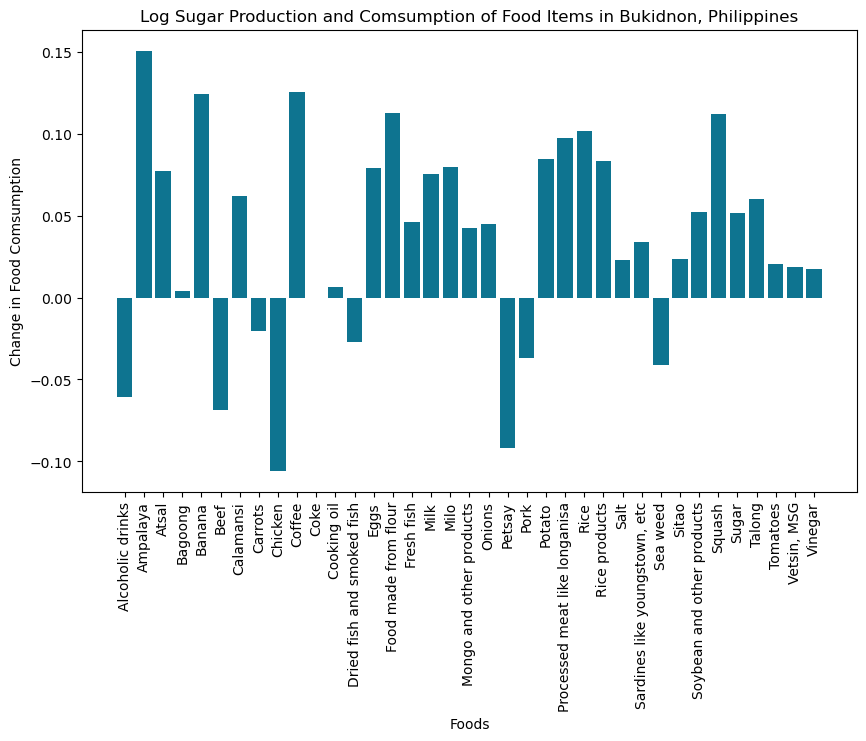

In [11]:
# Create a bar chart for log sugar production
def plot_gamma_table(gamma_table, variable_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Take the mean across the second dimension of the gamma table values array
    mean_values = gamma_table.values.mean(axis=1)

    ax.bar(gamma_table.index, mean_values, color='#0e7490')
    ax.set_title(f'Log {variable_name} Production and Comsumption of Food Items in Bukidnon, Philippines')
    ax.set_xlabel('Foods')
    ax.set_ylabel('Change in Food Comsumption')
    plt.xticks(rotation=90)
    plt.show()

    
# Plot the gamma table for log sugar production
plot_gamma_table(gamma_tables[0], 'Sugar')

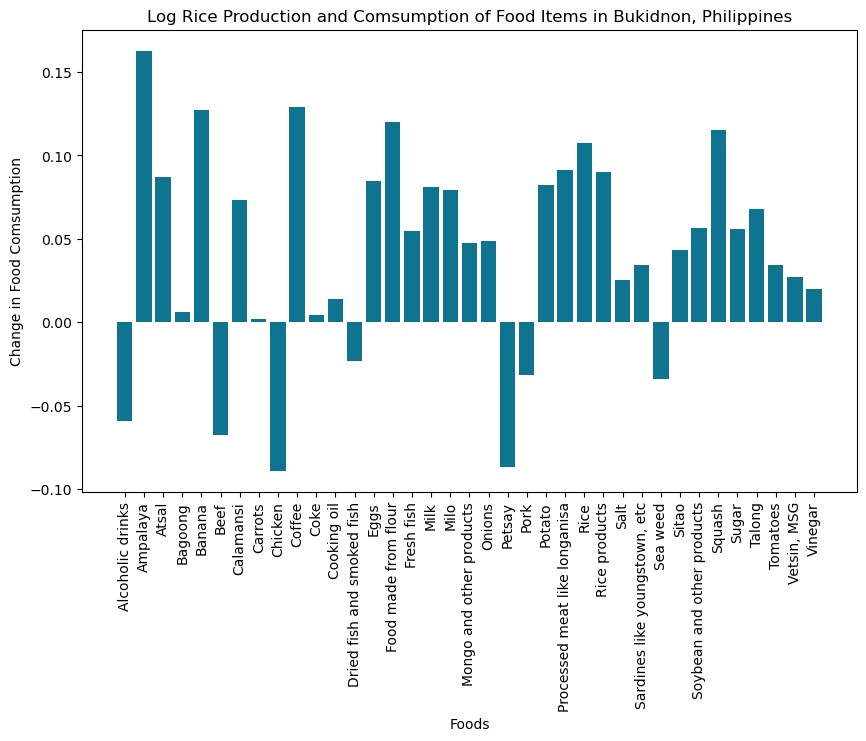

In [12]:
# Plot the gamma table for log rice production
plot_gamma_table(gamma_tables[1], 'Rice')

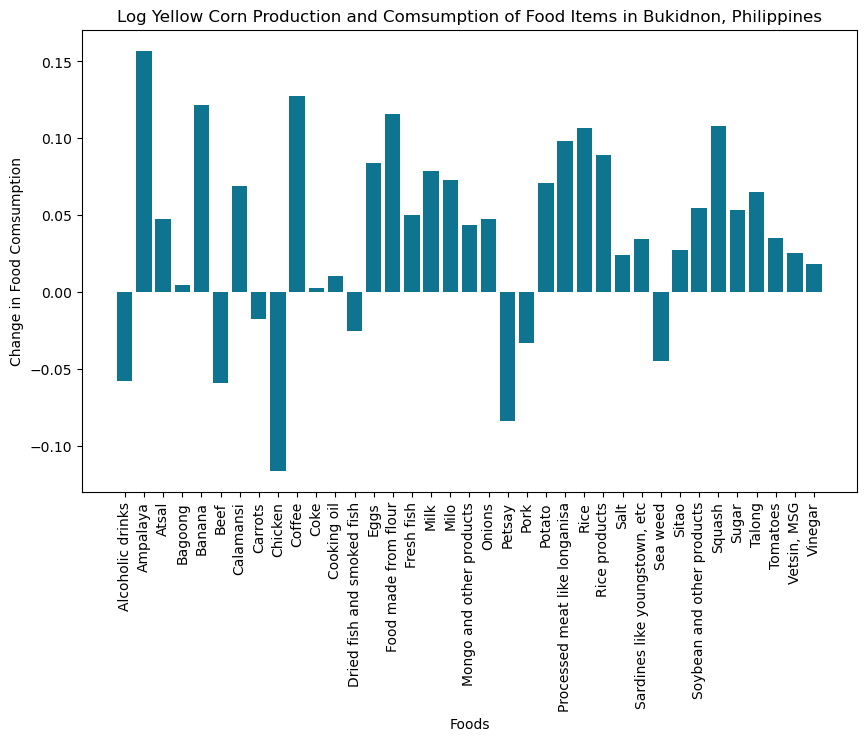

In [13]:
# Plot the gamma table for log yellow corn production
plot_gamma_table(gamma_tables[2], 'Yellow Corn')

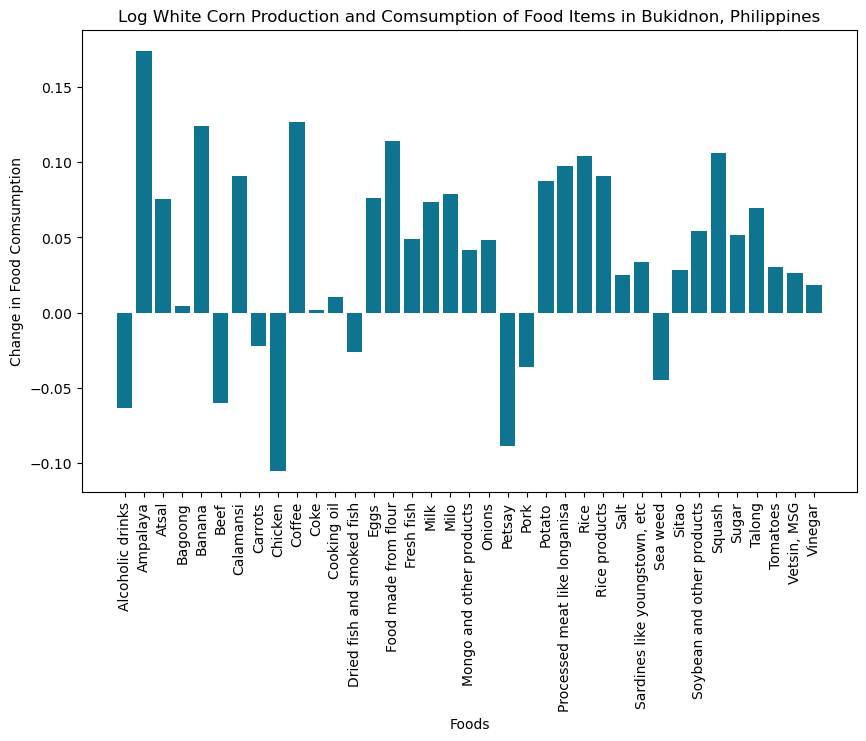

In [14]:
# Plot the gamma table for log white corn production
plot_gamma_table(gamma_tables[3], 'White Corn')

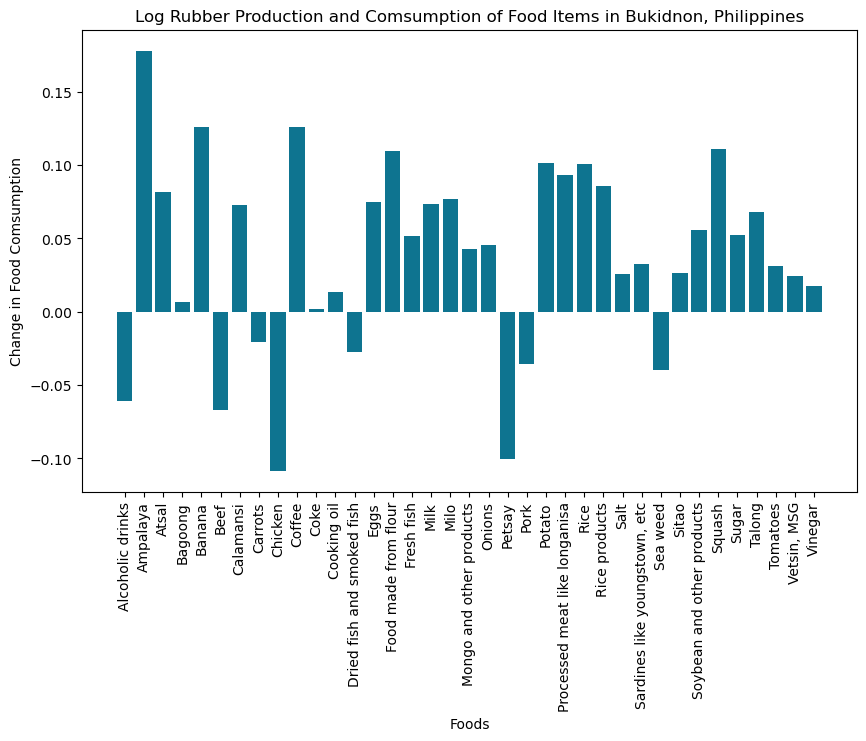

In [15]:
# Plot the gamma table for log rubber production
plot_gamma_table(gamma_tables[4], 'Rubber')

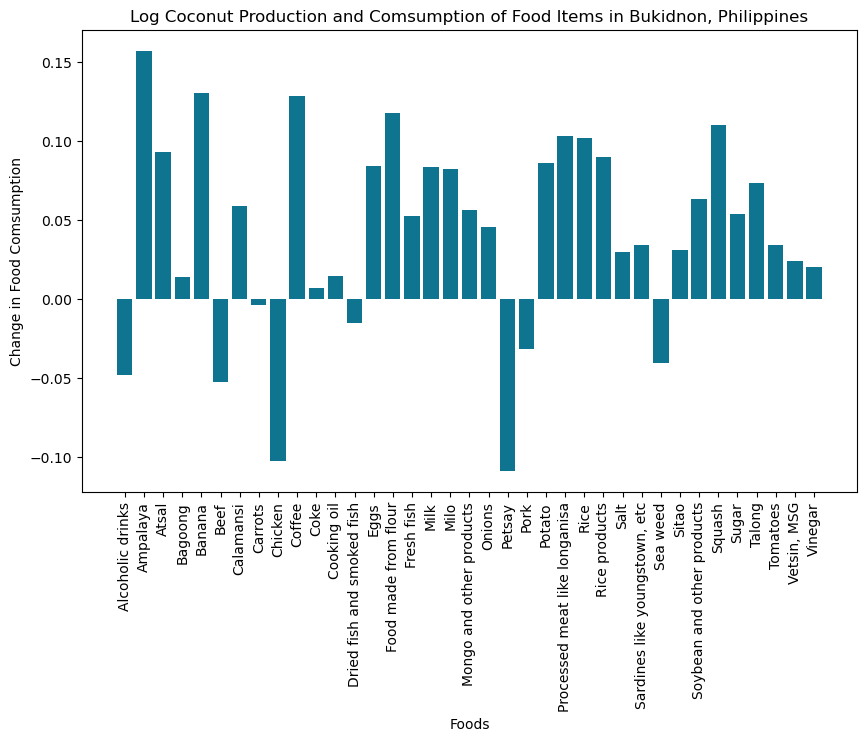

In [16]:
# Plot the gamma table for log coconut production
plot_gamma_table(gamma_tables[5], 'Coconut')

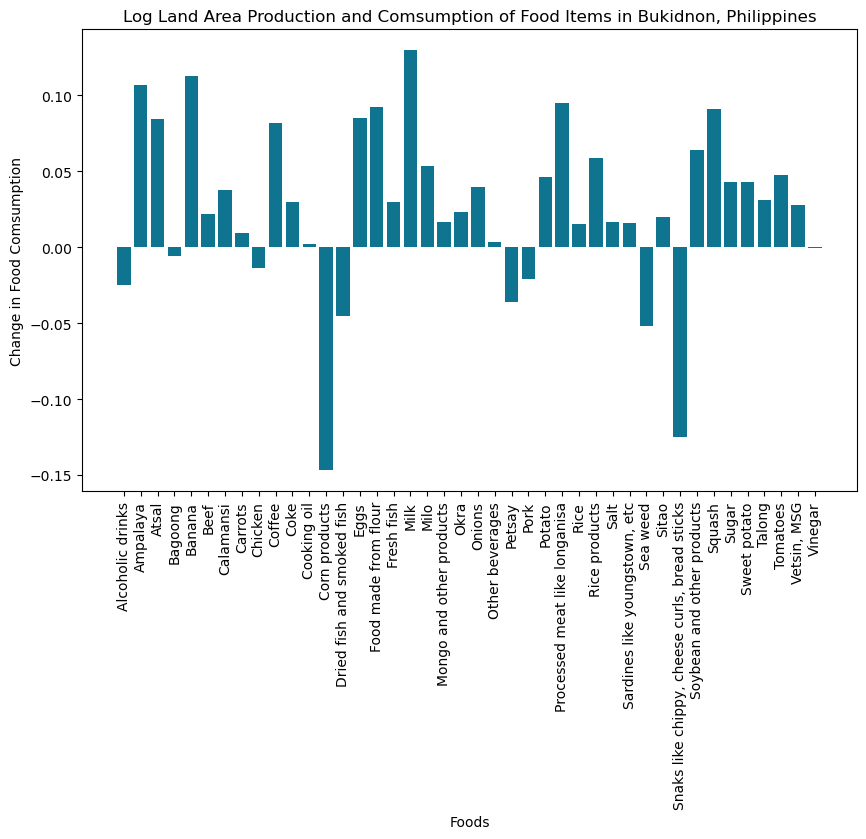

In [17]:
# Plot the gamma table for log land area
plot_gamma_table(gamma_tables[6], 'Land Area')

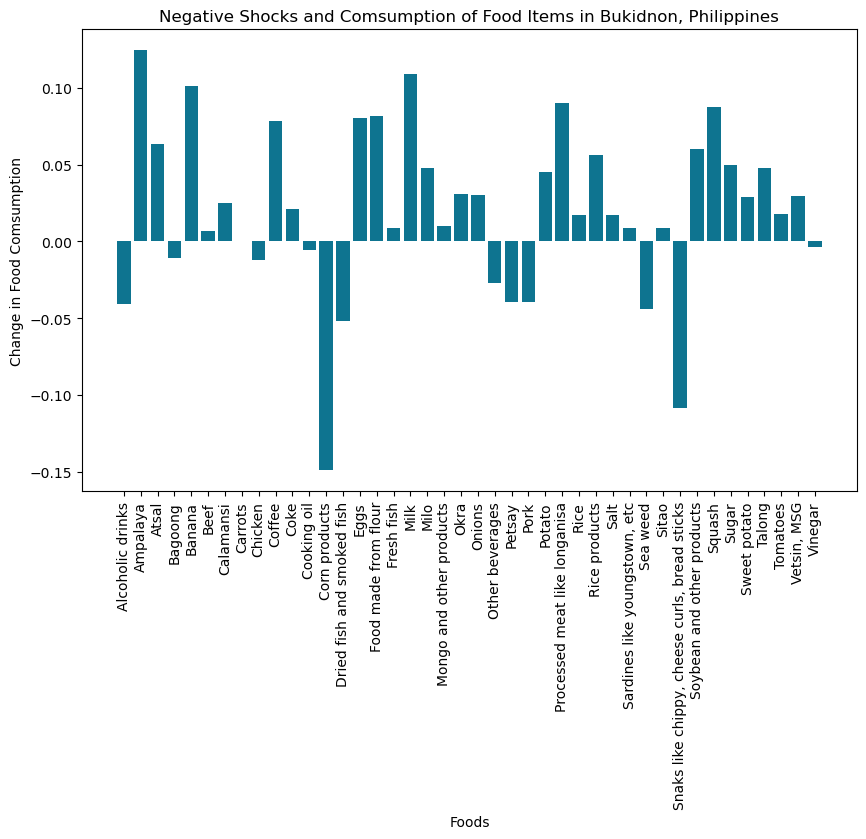

In [18]:
# Plot the gamma table for shocks
gamma_table = gamma_tables[7]
fig, ax = plt.subplots(figsize=(10, 6))

# Take the mean across the second dimension of the gamma table values array
mean_values = gamma_table.values.mean(axis=1)

ax.bar(gamma_table.index, mean_values, color='#0e7490')
ax.set_title('Negative Shocks and Comsumption of Food Items in Bukidnon, Philippines')
ax.set_xlabel('Foods')
ax.set_ylabel('Change in Food Comsumption')
plt.xticks(rotation=90)
plt.show()

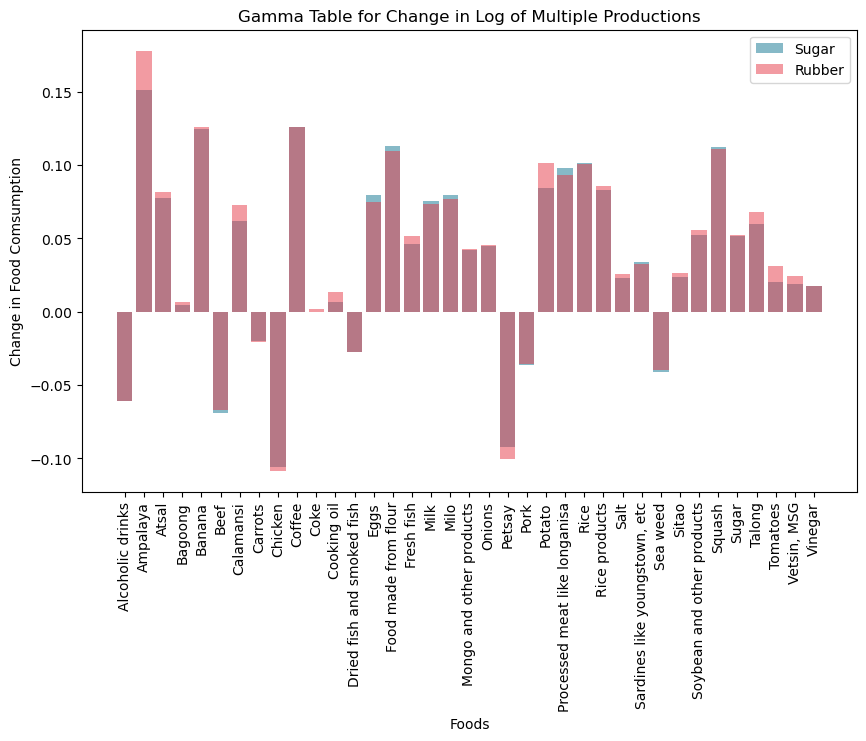

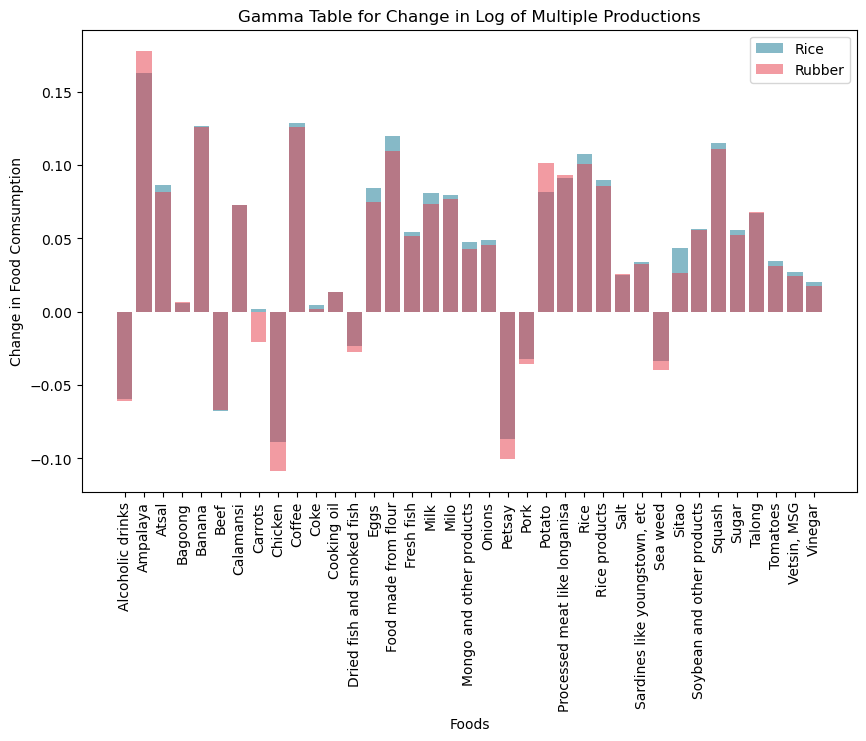

In [19]:
def plot_multiple_gamma_tables(gamma_tables, variable_names):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Set the common labels and title
    ax.set_title('Gamma Table for Change in Log of Multiple Productions')
    ax.set_xlabel('Foods')
    ax.set_ylabel('Change in Food Comsumption')
    plt.xticks(rotation=90)

    # Define colors for each production variable
    colors = ['#0e7490', '#e63946', '#f1c40f']

    for i, (gamma_table, variable_name) in enumerate(zip(gamma_tables, variable_names)):
        # Take the mean across the second dimension of the gamma table values array
        mean_values = gamma_table.values.mean(axis=1)
        
        # Create the bars with lowered opacity (alpha) and label them
        ax.bar(gamma_table.index, mean_values, color=colors[i % len(colors)], alpha=0.5, label=variable_name)

    # Add a legend to the graph
    ax.legend()
    plt.show()

plot_multiple_gamma_tables([gamma_tables[0], gamma_tables[4]], ['Sugar','Rubber'])
plot_multiple_gamma_tables([gamma_tables[1], gamma_tables[4]], ['Rice','Rubber'])

In [20]:
# regression with all variables
result = Regression(y=y,d=d)
x_hat = result.predicted_expenditures().unstack(level=3)
x_hat.reset_index(inplace=True)
x_hat.set_index(['i', 't', 'm'], inplace=True)
x_hat

,,j,Alcoholic drinks,Ampalaya,Atsal,Bagoong,Banana,Beef,Calamansi,Carrots,Chicken,Coffee,...,"Sardines like youngstown, etc",Sea weed,Sitao,Soybean and other products,Squash,Sugar,Talong,Tomatoes,"Vetsin, MSG",Vinegar
i,t,m,,,,,,,,,,,,,,,,,,,,,
2,2003,Bukidnon,8.837490,5.595471,5.763640,5.069240,30.376846,35.034891,13.705852,3.473736,60.633610,12.947293,...,12.888622,3.199094,15.429875,11.326157,4.729369,20.444168,16.783744,10.592812,6.363250,3.973340
4,2003,Bukidnon,59.611765,9.297498,16.604706,13.661939,29.156999,64.016258,4.228126,10.445394,74.300178,21.314257,...,29.365874,20.931682,8.471014,12.858778,13.405974,20.727400,19.429854,10.484085,7.102215,4.535600
6,2003,Bukidnon,94.707909,20.001961,20.037246,15.783777,36.019099,48.454684,14.960442,18.306095,105.429020,18.224108,...,61.447568,33.582734,10.513327,12.354725,13.675117,29.163505,28.732952,20.532418,8.311588,6.437665
12,2003,Bukidnon,86.396601,14.663271,10.518822,25.172667,8.054236,30.716561,3.779851,8.201916,177.979767,11.884390,...,28.089876,10.895167,7.686834,12.558522,6.569750,26.073781,17.220798,3.551033,12.729370,10.562458
14,2003,Bukidnon,15.358105,7.073477,1.886139,5.134579,8.729939,14.991047,4.395172,6.379522,46.070030,7.189100,...,10.007797,7.096854,4.810424,5.395753,3.947421,13.329483,7.930455,2.487661,4.673551,3.026555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,2003,Bukidnon,46.713707,14.757984,10.904599,12.433247,33.712963,108.577788,12.276025,5.314681,88.480157,18.570486,...,27.604151,9.283627,9.620937,13.994648,4.601325,26.245815,19.705316,8.320748,7.731092,2.852023
935,2003,Bukidnon,29.754797,14.079980,16.629917,12.220452,22.294530,43.367288,7.454031,3.521644,99.792999,24.057916,...,28.084423,13.380472,13.349211,14.201580,5.174889,31.016062,15.166971,8.875058,10.702333,4.884867
936,2003,Bukidnon,49.390515,13.121219,11.604247,7.727654,18.270937,88.031840,7.994732,7.059963,37.266982,12.752760,...,14.316009,15.115982,9.050624,11.327947,7.342369,19.046047,15.492908,15.541405,7.132196,2.686073


In [21]:
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
x_hat.to_csv('out.zip', index=False,
          compression=compression_opts)  

<IPython.core.display.Javascript object>


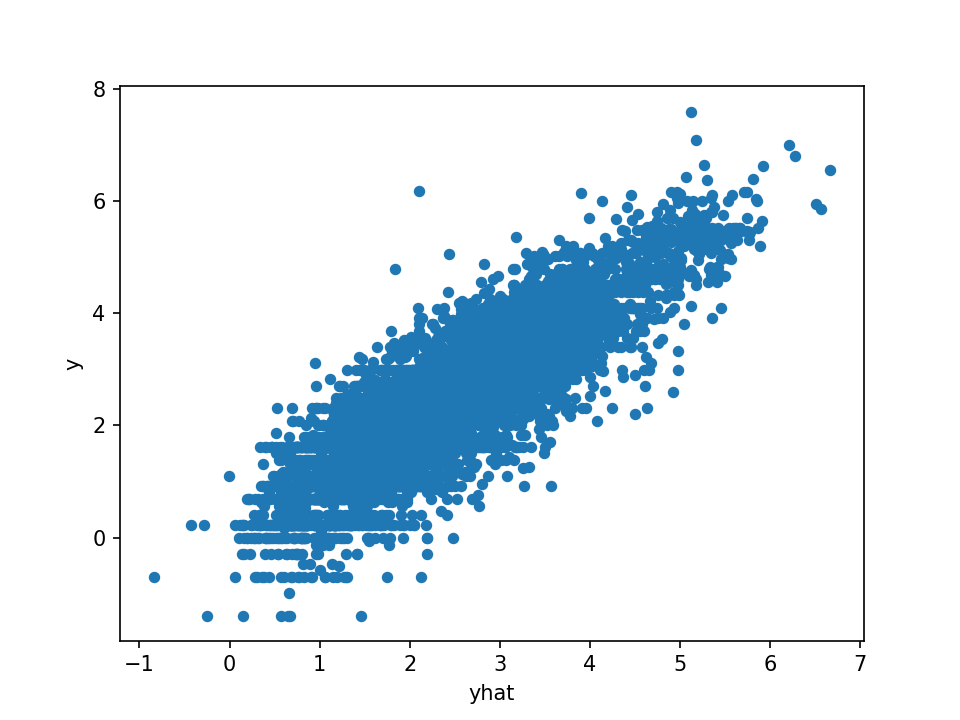

<AxesSubplot:xlabel='yhat', ylabel='y'>

In [22]:
%matplotlib notebook
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

<IPython.core.display.Javascript object>


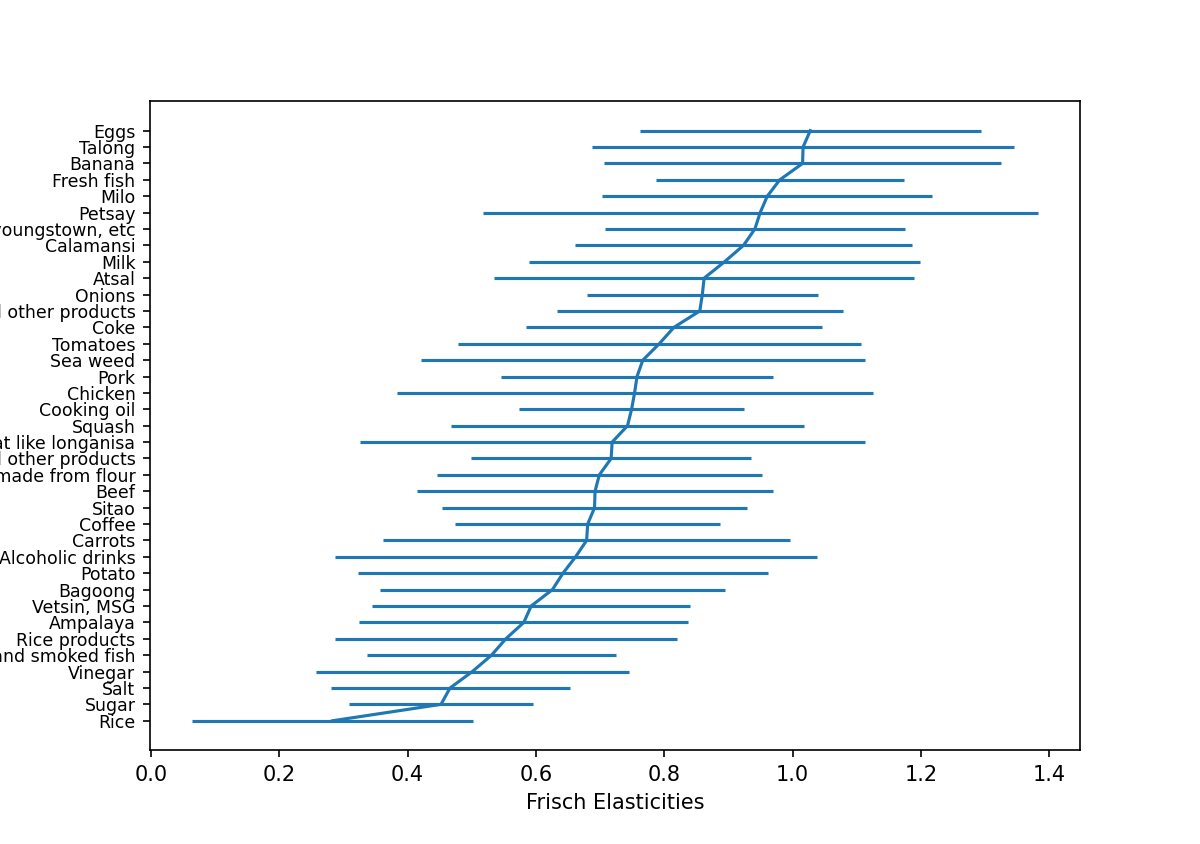

k,Males 0-1,Males 1-5,Males 5-10,Males 10-15,Males 15-20,Males 20-30,Males 30-50,Males 50-60,Males 60-100,Females 0-1,...,log HSize,logSugar,logRice,logYellow Corn,logWhite Corn,logRubber,logCoconut,logLand Area,Had Shocks,Constant
j,,,,,,,,,,,,,,,,,,,,,
Alcoholic drinks,0.211420,0.319409,0.068585,-0.284011,0.205210,0.099111,0.154595,-0.167062,-0.286902,-0.632918,...,-0.044192,0.000015,0.008802,0.010752,-0.030307,-0.018640,0.066784,0.228662,0.110355,-0.416642
Ampalaya,0.243134,0.428704,0.376099,0.355313,0.325800,0.326627,0.184713,0.231794,0.155713,-0.540194,...,-2.025655,0.018607,0.024658,0.003451,0.065277,-0.039064,0.013007,0.115329,0.056643,1.321389
Atsal,0.037141,0.177709,0.326849,-0.039619,0.151963,0.130189,0.062969,0.522491,0.145574,-0.396149,...,-0.478112,0.031329,0.021162,0.076356,-0.018286,-0.000766,0.043849,0.095464,-0.451711,0.106198
Bagoong,0.268694,0.162427,0.068400,-0.032739,0.085529,0.090474,0.076490,0.300520,0.188829,-0.402859,...,0.109144,0.013736,-0.004379,0.000859,-0.000107,-0.003674,0.064823,-0.046811,-0.061927,-0.650908
Banana,0.098976,0.187982,0.417660,0.266557,-0.005976,0.011891,-0.144589,0.477450,0.432842,-0.043951,...,-0.751432,0.032916,-0.001507,0.041125,0.003918,0.012310,0.025566,0.175151,-0.093327,0.069995
Beef,-0.472945,-0.000274,0.176368,0.013105,-0.084023,-0.013525,0.161867,0.491694,0.011705,-0.663709,...,0.196950,0.040961,0.009770,0.021806,0.019627,-0.011918,0.025201,0.214885,-0.638935,-0.480056
Calamansi,-0.106094,-0.089183,0.358085,0.301803,0.213628,0.024640,0.025076,-0.517319,0.001109,-0.061480,...,-1.001994,0.058421,0.046930,0.034540,0.102630,0.039632,-0.074924,0.089471,-0.131318,0.395953
Carrots,0.039727,0.155762,-0.185133,0.074996,0.151806,-0.080362,-0.008389,-0.201242,0.007750,-0.611269,...,-0.372653,-0.019779,0.045970,-0.002045,-0.000290,-0.020192,0.057481,0.107493,-0.075853,-0.059706
Chicken,0.147379,-0.049861,0.423724,-0.109950,-0.104897,-0.049921,-0.068498,0.130306,-0.101140,-0.478120,...,0.826245,-0.000616,0.056901,0.014425,0.036194,-0.045394,0.029593,0.193354,-0.007721,-1.758819


In [23]:
result.get_beta().sort_values()
result.graph_beta()
result.gamma

In [24]:
unit_vals = x_hat / q
p = unit_vals.median(axis = 0)
# get predicted quantities
q_hat = x_hat / p
q_hat
# Drop missing columns
q_hat = q_hat.loc[:,q_hat.count()>0]